In [17]:
import time
import numpy as np
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from cost_aware_snle_a import CostAwareSNLE_A
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import homogeneous_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : True
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [3]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [4]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Homo SIR

In [5]:
homo_sir = homogeneous_sir.HomoSIR()

## data generation

In [196]:
# DON'T NEED TO RUN
N = 50000

homo_sir_theta_npe_large = homo_sir.sample_theta([N]).reshape(-1, 1)
homo_sir_x_npe_large = torch.empty([N, 1])
for i in range(N):
    homo_sir_x_npe_large[i, :] = homo_sir(homo_sir_theta_npe_large[i])

In [50]:
# Use triton to generate data
N = 50000

homo_sir_theta_npe_large = torch.empty([N, homo_sir.theta_dim])
homo_sir_x_npe_large = torch.empty([N, homo_sir.x_dim])
for i in range(100):
    homo_sir_x_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/homo_sir_large/homo_sir_x_npe_large_{i+1}.pt")
    homo_sir_theta_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/homo_sir_large/homo_sir_theta_npe_large_{i+1}.pt")

torch.save(homo_sir_x_npe_large, "data/homo_sir_x_npe_large.pt")
torch.save(homo_sir_theta_npe_large, "data/homo_sir_theta_npe_large.pt")

In [100]:
# DON'T NEED TO RUN

# Observed data generation
homo_sir_obs_theta = torch.tensor([5])
homo_sir_obs_x = homo_sir(homo_sir_obs_theta)
homo_sir_obs_x

## data loading

In [101]:
# DON'T NEED TO RUN
# torch.save(homo_sir_x_npe_large, "data/homo_sir_x_npe_large.pt")
# torch.save(homo_sir_theta_npe_large, "data/homo_sir_theta_npe_large.pt")

# torch.save(homo_sir_obs_x, "data/homo_sir_obs_x.pt")
# torch.save(homo_sir_obs_theta, "data/homo_sir_obs_theta.pt")

In [23]:
homo_sir_x_npe_large = torch.load("data/homo_sir_x_npe_large.pt", weights_only=True)
homo_sir_theta_npe_large = torch.load("data/homo_sir_theta_npe_large.pt", weights_only=True)

homo_sir_obs_x = torch.load("data/homo_sir_obs_x.pt", weights_only=True)
homo_sir_obs_theta = torch.load("data/homo_sir_obs_theta.pt", weights_only=True)

## Fit GP

In [50]:
# for gp
n_train_pair = 100
X = homo_sir_theta_npe_large[:n_train_pair]
n_rep = 10

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = homo_sir(homo_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

In [52]:
# save GP training samples
torch.save(X, "data/homo_sir_gp_x.pt")
torch.save(times_train, "data/homo_sir_gp_y.pt")

In [53]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, 'data/homo_sir_gp.pth')


Iter 1/50 - Loss: 0.8623600006103516
Iter 2/50 - Loss: 0.8193010091781616
Iter 3/50 - Loss: 0.7764698266983032
Iter 4/50 - Loss: 0.7338752746582031
Iter 5/50 - Loss: 0.6914833188056946
Iter 6/50 - Loss: 0.6491745114326477
Iter 7/50 - Loss: 0.6067185997962952
Iter 8/50 - Loss: 0.5638237595558167
Iter 9/50 - Loss: 0.5202581286430359
Iter 10/50 - Loss: 0.4759351313114166
Iter 11/50 - Loss: 0.43090149760246277
Iter 12/50 - Loss: 0.38528403639793396
Iter 13/50 - Loss: 0.33924034237861633
Iter 14/50 - Loss: 0.29292720556259155
Iter 15/50 - Loss: 0.2464725524187088
Iter 16/50 - Loss: 0.19994987547397614
Iter 17/50 - Loss: 0.1533590704202652
Iter 18/50 - Loss: 0.10663307458162308
Iter 19/50 - Loss: 0.059685975313186646
Iter 20/50 - Loss: 0.012482071295380592
Iter 21/50 - Loss: -0.03492317348718643
Iter 22/50 - Loss: -0.0823875442147255
Iter 23/50 - Loss: -0.1297263354063034
Iter 24/50 - Loss: -0.17677658796310425
Iter 25/50 - Loss: -0.223459392786026
Iter 26/50 - Loss: -0.2698022425174713
Iter

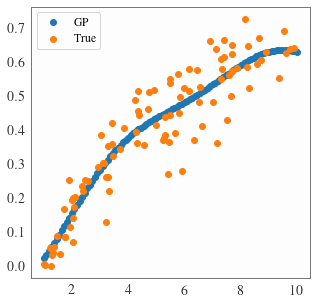

In [54]:
model.eval()
likelihood.eval()

x_test = torch.linspace(1, 10, 100).reshape(-1, 1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test)).mean

plt.figure(figsize=[5,5])
plt.scatter(x_test, observed_pred, label="GP")
plt.scatter(X, times_train, label="True")
plt.legend()
plt.show()

In [55]:
state_dicts = torch.load('data/homo_sir_gp.pth', weights_only=True)

X = torch.load("data/homo_sir_gp_x.pt", weights_only=True)
times_train = torch.load("data/homo_sir_gp_y.pt", weights_only=True)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
prior_start = torch.tensor([1.]).reshape(-1, 1)
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 1])
count = 0
while count < num_sim:
    theta = homo_sir.sample_theta([1]).reshape(-1, 1)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

In [56]:
prior_end = torch.tensor([10.]).reshape(-1, 1)

g_min = likelihood(model(prior_start)).mean
g_max = likelihood(model(prior_end)).mean

print(g_min ** 0.5)
print(g_min ** 1)
print(g_min ** 2)

print(g_max ** 0.5)
print(g_max ** 1)
print(g_max ** 2)

tensor([0.1498], grad_fn=<PowBackward0>)
tensor([0.0225], grad_fn=<PowBackward0>)
tensor([0.0005], grad_fn=<PowBackward0>)
tensor([0.7929], grad_fn=<PowBackward0>)
tensor([0.6288], grad_fn=<PowBackward0>)
tensor([0.3953], grad_fn=<PowBackward0>)


In [10]:
w = likelihood(model(theta_tilde)).mean.detach() ** k

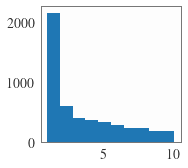

In [11]:
plt.hist(theta_tilde.detach().numpy(), bins=10)
plt.show()

In [81]:
x_npe = torch.empty([num_sim, 1])
for i in range(num_sim):
    x_npe[i, :] = homo_sir(theta_tilde[i])

In [82]:
homo_sir_inference_canpe = CostAwareSNPE_C()
homo_sir_nn_canpe = homo_sir_inference_canpe.append_simulations(
    theta_tilde, x_npe).append_weights(w).train()

In [83]:
# DON'T NEED TO RUN
homo_sir_post_canpe = homo_sir_inference_canpe.build_posterior(homo_sir_nn_canpe, prior=homo_sir.prior)
homo_sir_samples_canpe = homo_sir_post_canpe.sample((1000,), x=homo_sir_obs_x)

# torch.save(homo_sir_samples_npe_large, "data/homo_sir_post_reference.pt")

## inference NPE large

In [109]:
# DON'T NEED TO RUN
homo_sir_inference_npe_large = SNPE_C()
homo_sir_nn_npe_large = homo_sir_inference_npe_large.append_simulations(
    homo_sir_theta_npe_large, homo_sir_x_npe_large).train()

In [110]:
# DON'T NEED TO RUN
homo_sir_post_npe_large = homo_sir_inference_npe_large.build_posterior(homo_sir_nn_npe_large, prior=homo_sir.prior)
homo_sir_samples_npe_large = homo_sir_post_npe_large.sample((1000,), x=homo_sir_obs_x)

torch.save(homo_sir_samples_npe_large, "data/homo_sir_post_reference.pt")

In [12]:
homo_sir_post_reference = torch.load("data/homo_sir_post_reference.pt", weights_only=True)

## CEG ESS

In [15]:
num_sim = 2000
num_repeats = 1
k = np.array([0, 0.2, 0.4, 0.5, 1.0, 2.0]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = homo_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 1])
            count = 0
            while count < num_sim:
                param_value = homo_sir.sample_theta([1]).reshape(-1, 1)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
    print(ind)

In [18]:
ess_cost_aware * ceg

## Stats

In [32]:
def get_results(k, n_run):
    mmd_npe = torch.zeros([n_run])
    posterior_samples_npe = torch.zeros([n_run, 1000, 1])
    cost_npe = torch.zeros([n_run])
    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 1])
    cost_canpe = torch.zeros([n_run])
    
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/homo_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
        # posterior_npe = checkpoint["posterior_npe"]
        posterior_canpe = checkpoint["posterior_canpe"]
        
        # posterior_samples_npe[i] = posterior_npe.sample((1000,), x=homo_sir_obs_x, show_progress_bars=False)
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=homo_sir_obs_x, show_progress_bars=False)
        
        # mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], homo_sir_post_reference, lengthscale=median_heuristic(homo_sir_post_reference))
        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], homo_sir_post_reference, lengthscale=median_heuristic(homo_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
        
    mmd_npe = mmd_npe.detach().numpy() 
    mmd_npe_mean = np.mean(mmd_npe)
    mmd_npe_std = np.std(mmd_npe)
    
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)
    
    cost_npe = cost_npe.detach().numpy() 
    cost_npe_mean = np.mean(cost_npe)
    cost_npe_std = np.std(cost_npe)
    
    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    
    print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
    print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    
    print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

In [27]:
get_results('0.5', 50)

NPE MMD mean 0.02 (std 0.02)
CA-NPE MMD mean 0.01 (std 0.01)
NPE cost mean 10666.30 (std 2124.20)
CA-NPE cost mean 8898.98 (std 1784.17)
Cost saved: 0.1656455546617508(std 0.01455469336360693)


In [28]:
get_results('1.0', 50)

NPE MMD mean 0.02 (std 0.02)
CA-NPE MMD mean 0.02 (std 0.02)
NPE cost mean 15141.71 (std 3435.39)
CA-NPE cost mean 9223.35 (std 1932.19)
Cost saved: 0.3879559338092804(std 0.02361943945288658)


In [29]:
get_results('2.0', 50)

NPE MMD mean 0.02 (std 0.02)
CA-NPE MMD mean 0.23 (std 0.08)
NPE cost mean 14349.85 (std 3340.63)
CA-NPE cost mean 4230.03 (std 771.69)
Cost saved: 0.701174795627594(std 0.021970873698592186)


In [33]:
get_results('mixture', 50)

NPE MMD mean 0.00 (std 0.00)
CA-NPE MMD mean 0.05 (std 0.04)
NPE cost mean 13132.34 (std 511.94)
CA-NPE cost mean 9120.33 (std 470.77)
Cost saved: 0.3055262863636017(std 0.020696531981229782)


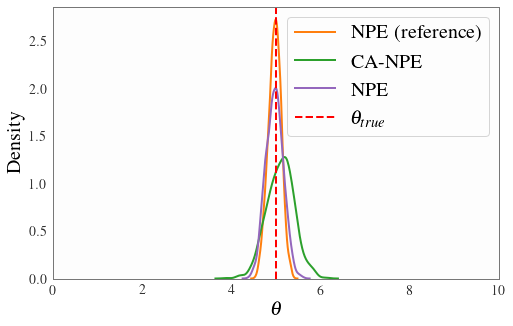

In [19]:
seed = 49
plt.figure(figsize=[8,5])
plt.xlim(0, 10)
sns.kdeplot(homo_sir_post_reference[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=homo_sir_obs_theta.detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=20)
plt.xlabel("$\\theta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
# plt.title(f"MMD:{mmd[seed]:.2f}")
plt.show()

# Cost plot

In [45]:
n_rep = 50

lamb = torch.arange(1, 10, 0.3)

In [46]:
N = lamb.shape[0]
homo_lamb = torch.zeros(N)
for i in range(N):
    print("progress: ", i)
    st = time.time()
    for _ in range(n_rep):
        result = homo_sir(lamb[i].reshape(-1))
    et = time.time()
    homo_lamb[i] = (et - st) / n_rep

print(homo_lamb)

progress:  0
progress:  1
progress:  2
progress:  3
progress:  4
progress:  5
progress:  6
progress:  7
progress:  8
progress:  9
progress:  10
progress:  11
progress:  12
progress:  13
progress:  14
progress:  15
progress:  16
progress:  17
progress:  18
progress:  19
progress:  20
progress:  21
progress:  22
progress:  23
progress:  24
progress:  25
progress:  26
progress:  27
progress:  28
progress:  29
tensor([0.0009, 0.0333, 0.0981, 0.1528, 0.1885, 0.2299, 0.2461, 0.2900, 0.3118,
        0.3055, 0.3280, 0.3241, 0.3963, 0.4030, 0.3724, 0.4534, 0.4546, 0.3764,
        0.4512, 0.5132, 0.5090, 0.4736, 0.5661, 0.5304, 0.5654, 0.5738, 0.5763,
        0.6287, 0.6760, 0.6235])


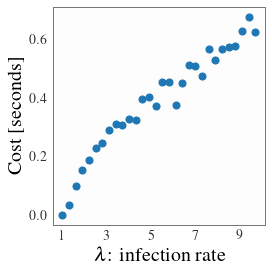

In [47]:
# Plotting figure
plt.figure(figsize=(4, 4))
plt.scatter(lamb, homo_lamb, s=50)
# plt.suptitle("        Homogeneous SIR", fontsize=20)
plt.xlabel("$\\lambda$: infection rate", fontsize=20)
plt.ylabel("Cost [seconds]", fontsize=20)
# plt.legend()
plt.xticks([1, 3, 5, 7, 9])

# plt.grid()
plt.tight_layout()
# plt.savefig("plot_cost_homo_sir.pdf")
plt.show()